# Lab 3: Quantitized Model Benchmarking Efficiency in Feed-Forward Neural Networks.

**Team Cyclops**


In [2]:
# Below is the code for building the network

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torchvision
from PIL import Image
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

trainPath = "./MNIST/mnist_train.csv"
testPath = "./MNIST/mnist_test.csv"

Device:  cpu


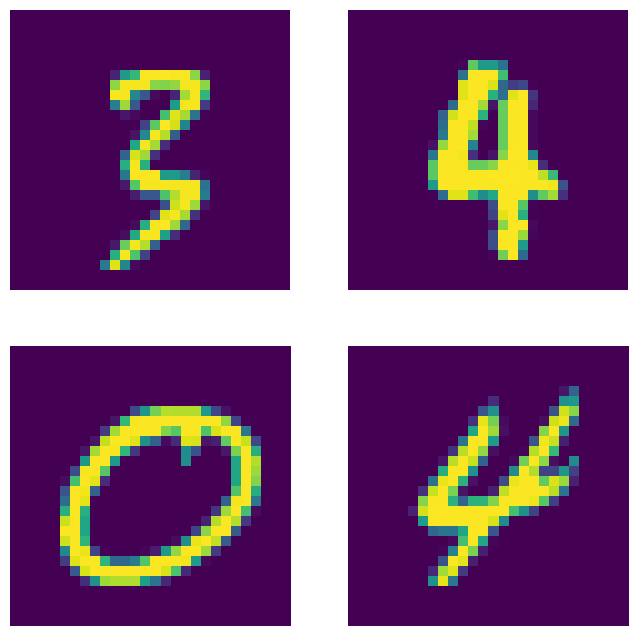

In [3]:
# Define Dataloader
class MNISTDataset(torch.utils.data.Dataset):

    def __init__(self, fileName: str, transform = None):
        self.X_Data, self.Y_Data = [], []

        with open(fileName, mode = 'r') as f:

            csvreader = csv.reader(f)

            for line in csvreader:
                row = list(map(int, line))

                pixels = row[1:]
                label = row[0]

                pixels = (pixels - np.mean(pixels, axis = 0))/np.std(pixels, axis = 0)

                self.X_Data.append(pixels)
                self.Y_Data.append(label)

        self.transform = transform
        self.length = len(self.Y_Data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        X_tensor = torch.FloatTensor(self.X_Data[idx])
        Y_tensor = torch.tensor(self.Y_Data[idx])

        if self.transform:
            X_tensor = self.transform(X_tensor)

        return X_tensor, Y_tensor



trainMNIST  = MNISTDataset(trainPath, None)
testMNIST = MNISTDataset(testPath, None)

train_loader_temp = torch.utils.data.DataLoader(
    dataset = trainMNIST,
    batch_size = 64,
    shuffle = True
)

test_loader_temp = torch.utils.data.DataLoader(
    dataset = testMNIST,
    batch_size = 64,
    shuffle = True
)


r, c = [2, 2]
fig, ax = plt.subplots(r, c, figsize= (8, 8))

k = 0

for data in train_loader_temp:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().reshape(28, 28)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k += 1

    break

del train_loader_temp, test_loader_temp

In [4]:
def trainLoop(inputModel, inputOptimizer, inputCriterion, dataloader, num_epochs = 2):

    startTime = time.time()

    # Looping over the epochs
    for epoch in range(num_epochs):

        # Putting the model in training loop
        inputModel.train()

        runningLoss = 0

        for pixels, labels in dataloader:

            # Zeroing the gradients
            inputOptimizer.zero_grad()

            # Forward Pass
            outputs = inputModel(pixels)
            loss = inputCriterion(outputs, labels)

            # Backprop
            loss.backward()
            inputOptimizer.step()

            runningLoss += loss.item()

        epochLoss = runningLoss/len(dataloader)
        # print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {epochLoss:.4f}')
    endTime = time.time()
    return (endTime - startTime)/num_epochs


def testLoop(inputModel, dataloader, batch_size):

    startTime = time.time()

    correct_predictions = 0
    total_predicitions = 0

    # Putting the model in evaluation mode
    inputModel.eval()

    # Ensuring no gradients are calculated
    with torch.no_grad():
        for pixels, numbers in dataloader:

            # Forward Pass
            outputs = inputModel(pixels)

            # Inference
            correct_predictions += torch.sum(torch.argmax(outputs, dim = 1) == numbers).item()
            total_predicitions += len(numbers)


    accuracy = 100 * correct_predictions/total_predicitions
    endTime = time.time()
    return accuracy, (endTime - startTime)/(len(dataloader)*batch_size)



# Computing the Parameters in the model
def getParams(inputModel):

    model_size = 0
    for f in inputModel.parameters():
        if f.requires_grad:

            model_size += f.numel()

    return model_size

# Computing FLOPS
def getFLOPS(inputModel):

    flops = 0

    for f in inputModel.parameters():
        if f.requires_grad:

            if f.ndim == 1:
                flops += 2*f.shape[0]
            else:
                flops += 2*f.shape[0]*f.shape[1]

    return flops

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

In [5]:
train_loader = torch.utils.data.DataLoader(
    dataset = trainMNIST,
    batch_size = 64,
    shuffle = True
)

test_loader_1 = torch.utils.data.DataLoader(
    dataset = testMNIST,
    batch_size = 1,
    shuffle = True
)

test_loader_64 = torch.utils.data.DataLoader(
    dataset = testMNIST,
    batch_size = 64,
    shuffle = True
)

# BaseLine Model
class BaselineMLP(torch.nn.Module):

    def __init__(self, input_size = 784, output_size = 10, hidden_size = 1024):

        super(BaselineMLP, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),

            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),

            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):

        out = self.model(x)
        return out

# Model Training

In [6]:
baseline_model  = BaselineMLP(input_size = 784, output_size = 10, hidden_size = 1024).to(device)
baseline_criterion = torch.nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr = 0.001)

predTime = trainLoop(inputModel = baseline_model, inputOptimizer = baseline_optimizer, inputCriterion = baseline_criterion, dataloader = train_loader, num_epochs = 2)
print("Training time per epoch: ", predTime)

print("Model precision: fp32")
model_size_storgae = print_size_of_model(baseline_model)

model_size_params = getParams(baseline_model)
print("Number of parameters: {}".format(model_size_params))

Training time per epoch:  36.86110031604767
Model precision: fp32
model:    	 Size (MB): 7.457066
Number of parameters: 1863690


### Batch Size 1

In [7]:
# Batch Size 1 experiments
all_accuracies_1, all_inference_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = baseline_model, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_1.append(baselineAcc)
    all_inference_1.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)


print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_1).std ()))

del all_accuracies_1, all_inference_1


Run- 1
Inference Time:  0.0006511002779006958
Testing Accuracy:  97.26

Run- 2
Inference Time:  0.0008302306890487671
Testing Accuracy:  97.26

Run- 3
Inference Time:  0.0009377162933349609
Testing Accuracy:  97.26

Run- 4
Inference Time:  0.0007250999927520752
Testing Accuracy:  97.26

Run- 5
Inference Time:  0.0008703519821166992
Testing Accuracy:  97.26


Average Accuracy: 97.26
Average Inference Time: 0.0008028998470306397
Std Inference Time: 0.00010253600944157743


### Batch Size 64

In [8]:
# Batch Size 64 experiments
all_accuracies_64, all_inference_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = baseline_model, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_64.append(baselineAcc)
    all_inference_64.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_64).std ()))

del all_accuracies_64, all_inference_64


Run- 1
Inference Time:  0.00010992743217261733
Testing Accuracy:  97.26

Run- 2
Inference Time:  0.00010708097819310085
Testing Accuracy:  97.26

Run- 3
Inference Time:  0.00010973682544033998
Testing Accuracy:  97.26

Run- 4
Inference Time:  0.00010689511705356039
Testing Accuracy:  97.26

Run- 5
Inference Time:  0.00010886543970199147
Testing Accuracy:  97.26


Average Accuracy: 97.26
Average Inference Time: 0.000108501158512322
Std Inference Time: 1.2876421399255966e-06


# Dynamic quantization in PyTorch

In [9]:
from torch.quantization.quantize_fx import prepare_fx, prepare_qat_fx, convert_fx

## Float 16 Quantization

In [10]:
torch.backends.quantized.engine = 'fbgemm'
model_dynamic_float_16 = torch.quantization.quantize_dynamic(baseline_model, {torch.nn.Linear}, dtype=torch.float16)

print("Model precision: float16")
model_size_storgae = print_size_of_model(model_dynamic_float_16)

Model precision: float16
model:    	 Size (MB): 7.458946


### Batch Size 1

In [11]:
# Batch Size 1 experiments
all_accuracies_float16_1, all_inference_float16_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_float_16, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_float16_1.append(baselineAcc)
    all_inference_float16_1.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)


print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_float16_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_float16_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_float16_1).std ()))

del all_accuracies_float16_1, all_inference_float16_1


Run- 1
Inference Time:  0.0007602653503417969
Testing Accuracy:  97.26

Run- 2
Inference Time:  0.0007257496356964111
Testing Accuracy:  97.26

Run- 3
Inference Time:  0.0007013635396957398
Testing Accuracy:  97.26

Run- 4
Inference Time:  0.0007522077798843384
Testing Accuracy:  97.26

Run- 5
Inference Time:  0.0007139513254165649
Testing Accuracy:  97.26


Average Accuracy: 97.26
Average Inference Time: 0.0007307075262069703
Std Inference Time: 2.237117057013723e-05


### Batch Size 64

In [12]:
# Batch Size 64 experiments
all_accuracies_float16_64, all_inference_float16_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_float_16, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_float16_64.append(baselineAcc)
    all_inference_float16_64.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_float16_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_float16_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_float16_64).std ()))

del all_accuracies_float16_64, all_inference_float16_64


Run- 1
Inference Time:  0.00010344044418091987
Testing Accuracy:  97.26

Run- 2
Inference Time:  0.00011499233211681342
Testing Accuracy:  97.26

Run- 3
Inference Time:  0.00016427047218486762
Testing Accuracy:  97.26

Run- 4
Inference Time:  0.00013517341606176584
Testing Accuracy:  97.26

Run- 5
Inference Time:  0.00010245544895245012
Testing Accuracy:  97.26


Average Accuracy: 97.26
Average Inference Time: 0.00012406642269936335
Std Inference Time: 2.3300365630687924e-05


# q INT8 Quantization

In [13]:
torch.backends.quantized.engine = 'qnnpack'
model_dynamic_q_int8 = torch.quantization.quantize_dynamic(baseline_model, {torch.nn.Linear}, dtype=torch.qint8)

print("Model precision: qint8")
model_size_storgae = print_size_of_model(model_dynamic_q_int8)

Model precision: qint8
model:    	 Size (MB): 1.87405


### Batch Size 1

In [14]:
# Batch Size 1 experiments
all_accuracies_qint8_1, all_inference_qint8_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_q_int8, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_qint8_1.append(baselineAcc)
    all_inference_qint8_1.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)


print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_1).std ()))

del all_accuracies_qint8_1, all_inference_qint8_1


Run- 1
Inference Time:  0.0016380500316619873
Testing Accuracy:  97.25

Run- 2
Inference Time:  0.002002140474319458
Testing Accuracy:  97.25

Run- 3
Inference Time:  0.0016841702461242675
Testing Accuracy:  97.25

Run- 4
Inference Time:  0.0017914504528045655
Testing Accuracy:  97.25

Run- 5
Inference Time:  0.0016788361310958863
Testing Accuracy:  97.25


Average Accuracy: 97.25
Average Inference Time: 0.001758929467201233
Std Inference Time: 0.00013177627255987995


### Batch Size 64

In [15]:
# Batch Size 64 experiments
all_accuracies_qint8_64, all_inference_qint8_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = model_dynamic_q_int8, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_qint8_64.append(baselineAcc)
    all_inference_qint8_64.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_64).std ()))

del all_accuracies_qint8_64, all_inference_qint8_64


Run- 1
Inference Time:  0.00023995959170305045
Testing Accuracy:  97.25

Run- 2
Inference Time:  0.0002377419999450635
Testing Accuracy:  97.28

Run- 3
Inference Time:  0.00037084398850513873
Testing Accuracy:  97.26

Run- 4
Inference Time:  0.0002378223428300991
Testing Accuracy:  97.28

Run- 5
Inference Time:  0.00023568625662736832
Testing Accuracy:  97.26


Average Accuracy: 97.266
Average Inference Time: 0.00026441083592214403
Std Inference Time: 5.3233740326144264e-05


# Static Quantization (q INT8)

In [16]:
from torch.quantization.quantize_fx import prepare_fx, prepare_qat_fx, convert_fx
qconfig_mapping = torch.ao.quantization.get_default_qconfig_mapping("qnnpack")
quantized_model = torch.ao.quantization.quantize_fx.prepare_fx(baseline_model, qconfig_mapping, torch.randn(784, 1000))

def calibrate(model, dataloader):
    model.eval()
    with torch.no_grad():
        for input in dataloader:
            model(input[0])

calibrate(quantized_model, train_loader)
static_quantized_model_int8 = torch.ao.quantization.quantize_fx.convert_fx(quantized_model)

print("Model precision: qint8")
model_size_storgae = print_size_of_model(model_dynamic_q_int8)

Model precision: qint8
model:    	 Size (MB): 1.87405


### Batch Size 1

In [17]:
# Batch Size 1 experiments
all_accuracies_qint8_1, all_inference_qint8_1 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = static_quantized_model_int8, dataloader = test_loader_1, batch_size = 1)

    all_accuracies_qint8_1.append(baselineAcc)
    all_inference_qint8_1.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_1).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_1).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_1).std ()))

del all_accuracies_qint8_1, all_inference_qint8_1


Run- 1
Inference Time:  0.0014089105367660522
Testing Accuracy:  97.31

Run- 2
Inference Time:  0.0013936184644699097
Testing Accuracy:  97.31

Run- 3
Inference Time:  0.0016366063117980957
Testing Accuracy:  97.31

Run- 4
Inference Time:  0.001569526243209839
Testing Accuracy:  97.31

Run- 5
Inference Time:  0.0013838932514190674
Testing Accuracy:  97.31


Average Accuracy: 97.31
Average Inference Time: 0.0014785109615325929
Std Inference Time: 0.00010419346191264418


### Batch Size 64

In [18]:
# Batch Size 64 experiments
all_accuracies_qint8_64, all_inference_qint8_64 = [], []
for i in range(5):
    print("\nRun-", (i + 1))
    baselineAcc, baselineInf = testLoop(inputModel = static_quantized_model_int8, dataloader = test_loader_64, batch_size = 64)

    all_accuracies_qint8_64.append(baselineAcc)
    all_inference_qint8_64.append(baselineInf)

    print("Inference Time: ", baselineInf)
    print("Testing Accuracy: ", baselineAcc)

print("\n\nAverage Accuracy: {}".format(np.array(all_accuracies_qint8_64).mean()))
print("Average Inference Time: {}".format(np.array(all_inference_qint8_64).mean()))
print("Std Inference Time: {}".format(np.array(all_inference_qint8_64).std ()))

del all_accuracies_qint8_64, all_inference_qint8_64


Run- 1
Inference Time:  0.0002102187721972253
Testing Accuracy:  97.31

Run- 2
Inference Time:  0.00034498812476540825
Testing Accuracy:  97.31

Run- 3
Inference Time:  0.00020422470892310902
Testing Accuracy:  97.31

Run- 4
Inference Time:  0.0002038094458306671
Testing Accuracy:  97.31

Run- 5
Inference Time:  0.00020741837419522037
Testing Accuracy:  97.31


Average Accuracy: 97.31
Average Inference Time: 0.000234131885182326
Std Inference Time: 5.547692135732306e-05
